## Harry Potter Sorting Hat using Random Forest

In [246]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from calendar import month_name
import re

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Load dataset

In [247]:
data = pd.read_csv('Characters.csv', sep=';')
data.head()

,Id,Name,Gender,Job,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Birth,Death
0,1,Harry James Potter,Male,Student,Gryffindor,"11"" Holly phoenix feather",Stag,Human,Half-blood,Black,Bright green,Albus Dumbledore | Dumbledore's Army | Order o...,Parseltongue| Defence Against the Dark Arts | ...,31 July 1980,NaN
1,2,Ronald Bilius Weasley,Male,Student,Gryffindor,"12"" Ash unicorn tail hair",Jack Russell terrier,Human,Pure-blood,Red,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Wizard chess | Quidditch goalkeeping,1 March 1980,NaN
2,3,Hermione Jean Granger,Female,Student,Gryffindor,"10¾"" vine wood dragon heartstring",Otter,Human,Muggle-born,Brown,Brown,Dumbledore's Army | Order of the Phoenix | Hog...,Almost everything,"19 September, 1979",NaN
3,4,Albus Percival Wulfric Brian Dumbledore,Male,Headmaster,Gryffindor,"15"" Elder Thestral tail hair core",Phoenix,Human,Half-blood,Silver| formerly auburn,Blue,Dumbledore's Army | Order of the Phoenix | Hog...,Considered by many to be one of the most power...,Late August 1881,"30 June, 1997"
4,5,Rubeus Hagrid,Male,Keeper of Keys and Grounds | Professor of Care...,Gryffindor,"16"" Oak unknown core",None,Half-Human/Half-Giant,Part-Human (Half-giant),Black,Black,Albus Dumbledore | Order of the Phoenix | Hogw...,Resistant to stunning spells| above average st...,6 December 1928,NaN


In [248]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            140 non-null    int64 
 1   Name          140 non-null    object
 2   Gender        139 non-null    object
 3   Job           121 non-null    object
 4   House         101 non-null    object
 5   Wand          132 non-null    object
 6   Patronus      130 non-null    object
 7   Species       140 non-null    object
 8   Blood status  123 non-null    object
 9   Hair colour   123 non-null    object
 10  Eye colour    86 non-null     object
 11  Loyalty       89 non-null     object
 12  Skills        113 non-null    object
 13  Birth         127 non-null    object
 14  Death         42 non-null     object
dtypes: int64(1), object(14)
memory usage: 16.5+ KB


/Users/adriellesilva/opt/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/adriellesilva/opt/anaconda3/envs/ml/lib/python3.8/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


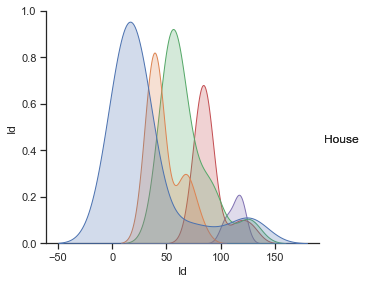

In [249]:
sns.set_theme(style="ticks")
g = sns.pairplot(data, hue='House', dropna=True, size=4)
g.add_legend()



## Missing values

In [250]:
# make a list of the variables that contain missing values and determine percentage of missing values

vars_with_na = [var for var in data.columns if data[var].isnull().sum() > 0]
data[vars_with_na].isnull().mean().sort_values(ascending=False)

Death           0.700000
Eye colour      0.385714
Loyalty         0.364286
House           0.278571
Skills          0.192857
Job             0.135714
Blood status    0.121429
Hair colour     0.121429
Birth           0.092857
Patronus        0.071429
Wand            0.057143
Gender          0.007143
dtype: float64

In [251]:
# replace the death date to a boolen indicator of death or not
# 0 = not Death; 1 = Death

data['Death'] = [0 if pd.isna(i) else 1 for i in data['Death']]


In [252]:
# variables to impute with the most frequent category

with_frequent_category = [var for var in vars_with_na if data[var].isnull().mean() < 0.2]

for var in with_frequent_category:
    # there can be more than 1 mode in a variable
    # we take the first one with [0]    
    mode = data[var].mode()[0]  
    print(var, mode)  
    data[var].fillna(mode, inplace=True)

Gender Male
Job Student
Wand Unknown
Patronus Unknown
Blood status Pure-blood or half-blood
Hair colour Black
Skills Chaser
Birth Pre 976
Death 0


In [253]:
# replace missing values with new label: "Missing"

data[['Eye colour','Loyalty']] = data[['Eye colour','Loyalty']].fillna('Missing')

In [254]:
# the characthers that does not have house associated
data_test = data[pd.isna(data['House'])]
data.drop(data[pd.isna(data['House'])].index, inplace=True)
data['House'].unique()

array(['Gryffindor', 'Ravenclaw', 'Slytherin', 'Hufflepuff',
       'Beauxbatons Academy of Magic', 'Durmstrang Institute'],
      dtype=object)

## Feature Engineering

In [255]:
# Extract month of birth

data['Birth month'] = data['Birth']
pattern = '|'.join(month_name[1:])

data['Birth month'] = data['Birth month'].apply(lambda x: month_name[:].index(re.search(pattern, x, re.IGNORECASE).group(0)) if re.search(pattern, x, re.IGNORECASE) else 0)      


In [257]:
# Extract year of birth

data['Birth year'] = data['Birth'].str.rstrip().str[-4:]
data['Birth year'] = data['Birth year'].apply(lambda x: x if x.isnumeric() else 0)      
data.drop(['Birth'], axis=1, inplace=True)


In [258]:
# Is a student?
data['Student'] = data['Job'].apply(lambda x: 1 if x == 'Student' else 0)
data.drop(['Job'], axis=1, inplace=True)

In [259]:
# Binary encoding for Gender

data['Gender_Female'] = data['Gender'].map({'Female':1, 'Male':0})
data.drop(['Gender'], axis=1, inplace=True)

In [260]:
#Label enconding

label_encoder = LabelEncoder()
features = ['Patronus','Species', 'Blood status', 'Hair colour', 'Loyalty', 'Eye colour']

for feat in features:
    data[feat] = label_encoder.fit_transform(data[feat])

data.head()

,Id,Name,House,Wand,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Skills,Death,Birth month,Birth year,Student,Gender_Female
0,1,Harry James Potter,Gryffindor,"11"" Holly phoenix feather",13,2,0,2,3,0,Parseltongue| Defence Against the Dark Arts | ...,0,7,1980,1,0
1,2,Ronald Bilius Weasley,Gryffindor,"12"" Ash unicorn tail hair",6,2,6,16,1,4,Wizard chess | Quidditch goalkeeping,0,3,1980,1,0
2,3,Hermione Jean Granger,Gryffindor,"10¾"" vine wood dragon heartstring",10,2,2,5,4,4,Almost everything,0,9,1979,1,1
3,4,Albus Percival Wulfric Brian Dumbledore,Gryffindor,"15"" Elder Thestral tail hair core",11,2,0,22,1,4,Considered by many to be one of the most power...,1,8,1881,0,0
4,5,Rubeus Hagrid,Gryffindor,"16"" Oak unknown core",9,1,5,2,0,1,Resistant to stunning spells| above average st...,0,12,1928,0,0


In [261]:
data.drop(['Wand', 'Skills','Id' ], axis=1, inplace=True)
data.head()

,Name,House,Patronus,Species,Blood status,Hair colour,Eye colour,Loyalty,Death,Birth month,Birth year,Student,Gender_Female
0,Harry James Potter,Gryffindor,13,2,0,2,3,0,0,7,1980,1,0
1,Ronald Bilius Weasley,Gryffindor,6,2,6,16,1,4,0,3,1980,1,0
2,Hermione Jean Granger,Gryffindor,10,2,2,5,4,4,0,9,1979,1,1
3,Albus Percival Wulfric Brian Dumbledore,Gryffindor,11,2,0,22,1,4,1,8,1881,0,0
4,Rubeus Hagrid,Gryffindor,9,1,5,2,0,1,0,12,1928,0,0


## ML

In [337]:
# Split the dataset
X = data.drop(['Name','House'],axis=1)
y = data['House']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=6)


X_train.shape, X_test.shape

((90, 11), (11, 11))

In [339]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

rfc = RandomForestClassifier(criterion='gini', max_features=2, max_depth=7, min_samples_leaf= 3, n_estimators=200)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [340]:
print(classification_report(y_test,predictions))

                              precision    recall  f1-score   support

Beauxbatons Academy of Magic       0.00      0.00      0.00         1
        Durmstrang Institute       0.00      0.00      0.00         1
                  Gryffindor       0.71      1.00      0.83         5
                  Hufflepuff       0.00      0.00      0.00         1
                   Ravenclaw       1.00      1.00      1.00         1
                   Slytherin       0.33      0.50      0.40         2

                    accuracy                           0.64        11
                   macro avg       0.34      0.42      0.37        11
                weighted avg       0.48      0.64      0.54        11



/Users/adriellesilva/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adriellesilva/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/adriellesilva/opt/anaconda3/envs/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [341]:
df = pd.DataFrame(y_test)
index = df.index
names = data.loc[index]['Name']

In [342]:
df_results = pd.DataFrame({'Name': data.loc[index]['Name'],
                           'House': data.loc[index]['House'],
                           'House Predict':predictions})

df_results.head(20)

,Name,House,House Predict
0,Harry James Potter,Gryffindor,Gryffindor
45,Severus Snape,Slytherin,Gryffindor
27,Colin Creevey,Gryffindor,Gryffindor
44,Anthony Goldstein,Ravenclaw,Ravenclaw
46,Draco Malfoy,Slytherin,Slytherin
87,Ernest Macmillan,Hufflepuff,Gryffindor
20,Oliver Wood,Gryffindor,Gryffindor
29,Minerva McGonagall,Gryffindor,Gryffindor
116,Madame Olympe Maxime,Beauxbatons Academy of Magic,Slytherin
118,Viktor Krum,Durmstrang Institute,Slytherin
